In [8]:
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt
# ใน Google Colab ต้องใช้ ee.Authenticate() แทน earthengine authenticate เพราะ Colab ไม่มี CLI เหมือนเครื่อง Local
ee.Authenticate()

# ตรวจสอบและเริ่มต้นการเชื่อมต่อ GEE
try:
    ee.Initialize(project="ee-sakda-451407")
except Exception as e:
    ee.Authenticate() # หากยังไม่ได้ยืนยันตัวตน ให้ทำการยืนยัน
    ee.Initialize(project="ee-sakda-451407")  

In [ ]:
# 1.1 กำหนดขอบเขตพื้นที่ศึกษา (Area of Interest - AOI)
aoi = ee.FeatureCollection("projects/ee-sakda-451407/assets/nan_subbasin");

# สร้างแผนที่และตั้งศูนย์
Map = geemap.Map()
Map.center_object(aoi, 9)

# 1.2 กำหนดช่วงเวลาที่ศึกษา
start_date = '2022-01-01'
end_date = '2022-12-31'

# 1.3 โหลดข้อมูลการใช้ที่ดิน/ที่ดินปกคลุม (LULC)
lulc = ee.Image('ESA/WorldCover/v200/2021').select('Map').clip(aoi)

# 1.4 โหลดข้อมูลดินแบบ USDA Soil Texture
soil_texture = (
    ee.Image('OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02')
      .select('b0')
      .clip(aoi)
      .rename('soil_texture')
)

# 1.5 โหลดข้อมูลฝนรายวันจาก CHIRPS และเพิ่ม band 'p'
precip = (
    ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
      .filterDate(ee.Date(start_date).advance(-5, 'day'), ee.Date(end_date))
      .select('precipitation')
      .map(lambda img: img.rename('p').copyProperties(img, ['system:time_start']))
)

# แสดงเลเยอร์เบื้องต้นบนแผนที่
Map.add_layer(lulc, {'min':10, 'max':95, 'palette':['006400','ffbb22','ffff4c','f096ff','fa0000','b4b4b4','f0f0f0','0064c8','0096a0','00cf75']}, 'ESA WorldCover LULC')
Map.add_layer(soil_texture, {'min':1, 'max':12, 'palette':['d5c36b','b96947','9d3722','74281a']}, 'Soil Texture')
precip_sum = precip.sum().clip(aoi)
Map.add_layer(precip_sum, {'min':500, 'max':1800, 'palette':['001137','0aab1e','e7eb05','ff4a2d','e90000']}, 'Precipitation')

In [16]:
# กำหนดพารามิเตอร์ทางอุทกวิทยา
hsg = (
    soil_texture.remap(
        [1,2,3,4,5,6,7,8,9,10,11,12],
        [4,4,4,3,3,3,2,2,2,1,1,1],
        4
    ).rename('hsg')
)
cn_lookup = {10:[55,70,80,85],20:[48,66,77,83],30:[61,74,82,86],40:[67,78,85,89],50:[75,85,90,92],60:[86,91,94,96],70:[98,98,98,98],80:[100,100,100,100],90:[100,100,100,100],95:[55,70,80,85]}
cn2 = ee.Image(0).clip(aoi)
for lc, vals in cn_lookup.items():
    cn_img = hsg.expression(
        '(hsg == 1) ? ca : (hsg == 2) ? cb : (hsg == 3) ? cc : cd',
        {'hsg':hsg, 'ca':vals[0], 'cb':vals[1], 'cc':vals[2], 'cd':vals[3]}
    )
    cn2 = cn2.where(lulc.eq(lc), cn_img)
cn2 = cn2.rename('cn2').set('description', 'Curve Number for AMC II')
cn1 = cn2.expression('(4.2 * CN2) / (10 - 0.058 * CN2)', {'CN2':cn2}).rename('cn1')
cn3 = cn2.expression('(23 * CN2) / (10 + 0.13 * CN2)', {'CN2':cn2}).rename('cn3')
s1 = cn1.expression('(25400 / CN1) - 254', {'CN1':cn1}).rename('s1')
s2 = cn2.expression('(25400 / CN2) - 254', {'CN2':cn2}).rename('s2')
s3 = cn3.expression('(25400 / CN3) - 254', {'CN3':cn3}).rename('s3')
Map.add_layer(cn2, {'min':30, 'max':100, 'palette':['green','yellow','red','purple']}, 'Curve Number (CN-II)')

In [19]:
# คำนวณน้ำท่า (Runoff)
def add_p5(image):
    date = ee.Date(image.get('system:time_start'))
    p5 = (
        precip.filterDate(date.advance(-5, 'day'), date.advance(-1, 'day'))
              .select('p')
              .sum()
              .rename('p5')
              .unmask(0)
    )
    return image.addBands(p5).copyProperties(image, ['system:time_start'])

p5_col = precip.filterDate(start_date, end_date).map(add_p5)

def calc_runoff(image):
    p = image.select('p')
    p5 = image.select('p5')
    amc = p5.expression(
        '(p5 < 20) ? 1 : (p5 > 40) ? 3 : 2', {'p5':p5}
    ).rename('amc')
    s_dyn = (
        ee.Image(0).clip(aoi)
        .where(amc.eq(1), s1)
        .where(amc.eq(2), s2)
        .where(amc.eq(3), s3)
        .rename('s_dynamic')
    )
    ia = s_dyn.multiply(0.2).rename('ia')
    q = p.expression(
        '(P > Ia) ? ((P - Ia) * (P - Ia)) / (P - Ia + S) : 0',
        {'P':p, 'Ia':ia, 'S':s_dyn}
    ).max(0).rename('runoff_mm')
    return image.addBands(q).addBands(p).addBands(s_dyn).copyProperties(image, ['system:time_start'])

runoff_col = p5_col.map(calc_runoff)
total_runoff = runoff_col.select('runoff_mm').sum().clip(aoi)
Map.add_layer(total_runoff, {'min':0, 'max':2000, 'palette':['white','blue','darkblue','purple']}, 'Total Runoff (mm)')

# แสดงแผนที่
Map

Map(bottom=935828.0, center=[19.04524319840766, 100.8245372772217], controls=(WidgetControl(options=['position…

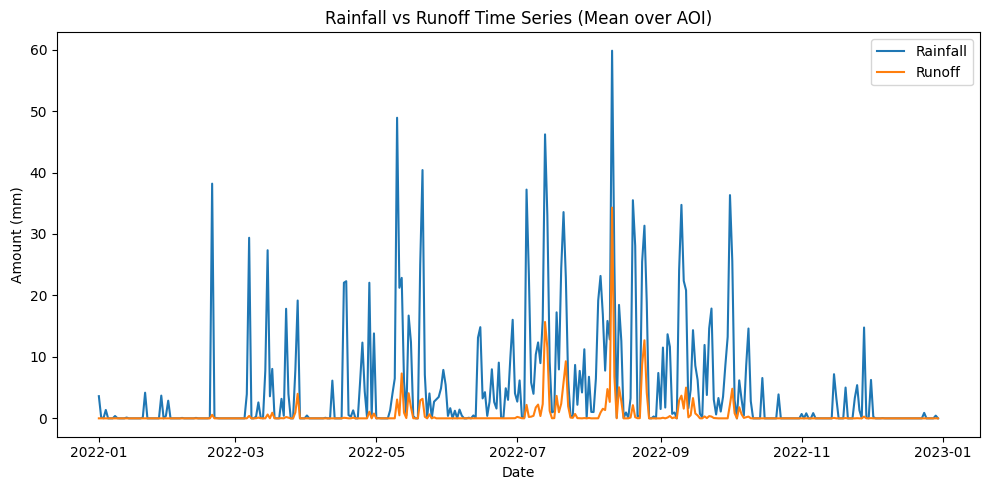

In [18]:
# สร้าง FeatureCollection ของสถิติรายวัน
stats_fc = runoff_col.map(lambda img: ee.Feature(None, {
    'date': img.get('system:time_start'),
    'p': img.select('p').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=5566,
        bestEffort=True
    ).get('p'),
    'runoff_mm': img.select('runoff_mm').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=5566,
        bestEffort=True
    ).get('runoff_mm')
}))

# ดึงข้อมูลลงมาเป็น Python list และแปลงเป็น DataFrame
features = stats_fc.getInfo()['features']
rows = []
for f in features:
    props = f['properties']
    rows.append({
        'date': pd.to_datetime(props['date'], unit='ms'),
        'precipitation': props['p'],
        'runoff_mm': props['runoff_mm']
    })
df = pd.DataFrame(rows).sort_values('date')

# แสดงกราฟ
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['precipitation'], label='Rainfall')
plt.plot(df['date'], df['runoff_mm'], label='Runoff')
plt.title('Rainfall vs Runoff Time Series (Mean over AOI)')
plt.xlabel('Date')
plt.ylabel('Amount (mm)')
plt.legend()
plt.tight_layout()
plt.show()

